In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# File path to your CSV file
file_path = 'data/BIST_DLY_THYAO, 1D_2b8b3.csv'

# Load the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Check the first few rows to understand the data structure
print("Data preview:")
print(data.head())

Data preview:
         time      open      high       low     close        Volume  Plot  \
0  1993-08-11  0.002254  0.002254  0.002200  0.002254  119736.26285   NaN   
1  1993-08-12  0.002254  0.002361  0.002146  0.002254  188689.44146   NaN   
2  1993-08-13  0.002361  0.002361  0.002200  0.002361  356413.38943   NaN   
3  1993-08-16  0.002576  0.002576  0.002361  0.002576  387628.67974   NaN   
4  1993-08-17  0.002576  0.002629  0.002361  0.002576  357345.18914   NaN   

   Plot.1  Plot.2  Plot.3  
0     NaN     NaN     NaN  
1     NaN     NaN     NaN  
2     NaN     NaN     NaN  
3     NaN     NaN     NaN  
4     NaN     NaN     NaN  


### Without a upper or lower bound on number of support/resistance lines.

In [32]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import mplfinance as mpf


In [93]:
def cluster_pivots(pivot_high_values, pivot_low_values, abs_eps=3, min_samples=1):
    """
    Unified clustering for support/resistance (S/R) levels using an absolute `eps`.

    Parameters:
        pivot_high_values (np.array): Array of high pivot values.
        pivot_low_values (np.array): Array of low pivot values.
        abs_eps (float): Absolute distance threshold for DBSCAN clustering.
        min_samples (int): Minimum number of points to form a cluster (default: 1).

    Returns:
        sr_levels (list): List of unified S/R levels.
    """
    # Combine high and low pivot values
    all_pivots = np.concatenate((pivot_high_values, pivot_low_values)).reshape(-1, 1)
    print(f"All Pivots for Clustering: {all_pivots.flatten()}")  # Debug

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=abs_eps, min_samples=min_samples)
    dbscan.fit(all_pivots)
    labels = dbscan.labels_

    # Print debugging information
    print(f"DBSCAN Labels: {labels}")
    unique_labels = set(labels)
    print(f"Unique Labels: {unique_labels}")
    for label in unique_labels:
        count = sum(labels == label)
        print(f"Cluster {label}: {count} points")

    # Extract cluster levels
    sr_levels = []
    for label in unique_labels:
        if label == -1:  # Skip noise points
            continue
        cluster_values = all_pivots[labels == label].flatten()
        sr_levels.append(cluster_values.mean())  # Use the mean of the cluster as the level

    # Ensure levels are sorted for better visualization
    return sorted(sr_levels)

In [94]:
def plot_and_save_candlestick_with_levels_corrected_pivots(
    csv_path, 
    start_date, 
    end_date, 
    abs_eps=3, 
    min_samples=1, 
    output_csv_path="output_with_levels.csv",
    pivot_window=5
):
    """
    Function to plot candlestick charts with corrected pivot point detection
    and unified S/R levels using absolute `eps`.
    """
    data = pd.read_csv(csv_path)
    data['time'] = pd.to_datetime(data['time'])
    data.set_index('time', inplace=True)
    filtered_data = data[(data.index >= start_date) & (data.index <= end_date)].copy()

    required_columns = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in filtered_data.columns for col in required_columns):
        raise ValueError(f"Input data must contain the following columns: {required_columns}")

    filtered_data['Pivot Highs'] = np.nan
    filtered_data['Pivot Lows'] = np.nan
    pivots = []

    for i in range(pivot_window, len(filtered_data)):
        current_high = filtered_data['high'].iloc[i]
        current_low = filtered_data['low'].iloc[i]
        preceding_highs = filtered_data['high'].iloc[i - pivot_window:i]
        preceding_lows = filtered_data['low'].iloc[i - pivot_window:i]

        is_pivot_high = current_high > preceding_highs.max()
        is_pivot_low = current_low < preceding_lows.min()

        if is_pivot_high:
            while pivots and pivots[-1][1] == 'high' and filtered_data['Pivot Highs'].iloc[pivots[-1][0]] < current_high:
                removed_pivot_index, _ = pivots.pop()
                filtered_data.at[filtered_data.index[removed_pivot_index], 'Pivot Highs'] = np.nan
            if not pivots or pivots[-1][1] == 'low':
                pivots.append((i, 'high'))
                filtered_data.at[filtered_data.index[i], 'Pivot Highs'] = current_high

        if is_pivot_low:
            while pivots and pivots[-1][1] == 'low' and filtered_data['Pivot Lows'].iloc[pivots[-1][0]] > current_low:
                removed_pivot_index, _ = pivots.pop()
                filtered_data.at[filtered_data.index[removed_pivot_index], 'Pivot Lows'] = np.nan
            if not pivots or pivots[-1][1] == 'high':
                pivots.append((i, 'low'))
                filtered_data.at[filtered_data.index[i], 'Pivot Lows'] = current_low
    print(f"\nTotal Pivots Detected: {len(pivots)}")

    pivot_high_values = filtered_data['Pivot Highs'].dropna().values
    pivot_low_values = filtered_data['Pivot Lows'].dropna().values

    if len(pivot_high_values) == 0 and len(pivot_low_values) == 0:
        print("No pivot points detected. Exiting function.")
        return filtered_data, []

    sr_levels = cluster_pivots(pivot_high_values, pivot_low_values, abs_eps, min_samples)

    print(f"Identified S/R Levels: {sr_levels}")

    # Prepare addplots for S/R levels
    add_lines = []
    for level in sr_levels:
        if level > filtered_data['low'].min() and level < filtered_data['high'].max():
            add_lines.append(mpf.make_addplot([level] * len(filtered_data), color='purple', linestyle='--'))

    pivot_highs_plot = mpf.make_addplot(filtered_data['Pivot Highs'], type='scatter', markersize=100, marker='^', color='green')
    pivot_lows_plot = mpf.make_addplot(filtered_data['Pivot Lows'], type='scatter', markersize=100, marker='v', color='red')

    mpf.plot(
        filtered_data,
        type='candle',
        style='charles',
        title=f'Candlestick Chart with Unified S/R Levels ({start_date} to {end_date})',
        ylabel='Price',
        volume=True,
        addplot=add_lines + [pivot_highs_plot, pivot_lows_plot],
        figsize=(14, 10),
        tight_layout=True
    )
    print("Candlestick chart plotted successfully.")

    return filtered_data, sr_levels

CSV Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'Plot', 'Plot.1', 'Plot.2', 'Plot.3']

Total Pivots Detected: 58
All Pivots for Clustering: [156.39999 152.8     143.39999 148.7     138.2     138.3     186.2
 220.60001 269.79999 258.60001 255.60001 224.2     269.25    256.5
 294.75    290.5     286.25    312.75    332.      330.      317.5
 318.75    308.      303.25    309.75    302.75    280.      293.75
 300.25    125.1     125.1     134.89999 133.5     115.9     124.1
 123.4     168.10001 208.60001 227.3     214.60001 205.2     203.
 221.60001 248.      277.5     260.75    267.75    291.75    303.5
 298.5     293.      271.25    282.75    287.75    280.      257.5
 267.      269.5    ]
DBSCAN Labels: [ 0  1  2  3  4  4  5  6  7  8  8  6  7  8  9  9  9 10 11 11 12 12 10 13
 10 13 14  9 13 15 15 16 16 17 15 15 18 19 20 21 22 22  6 23 14  8  7  9
 13 13  9  7 14  9 14  8  7  7]
Unique Labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5),

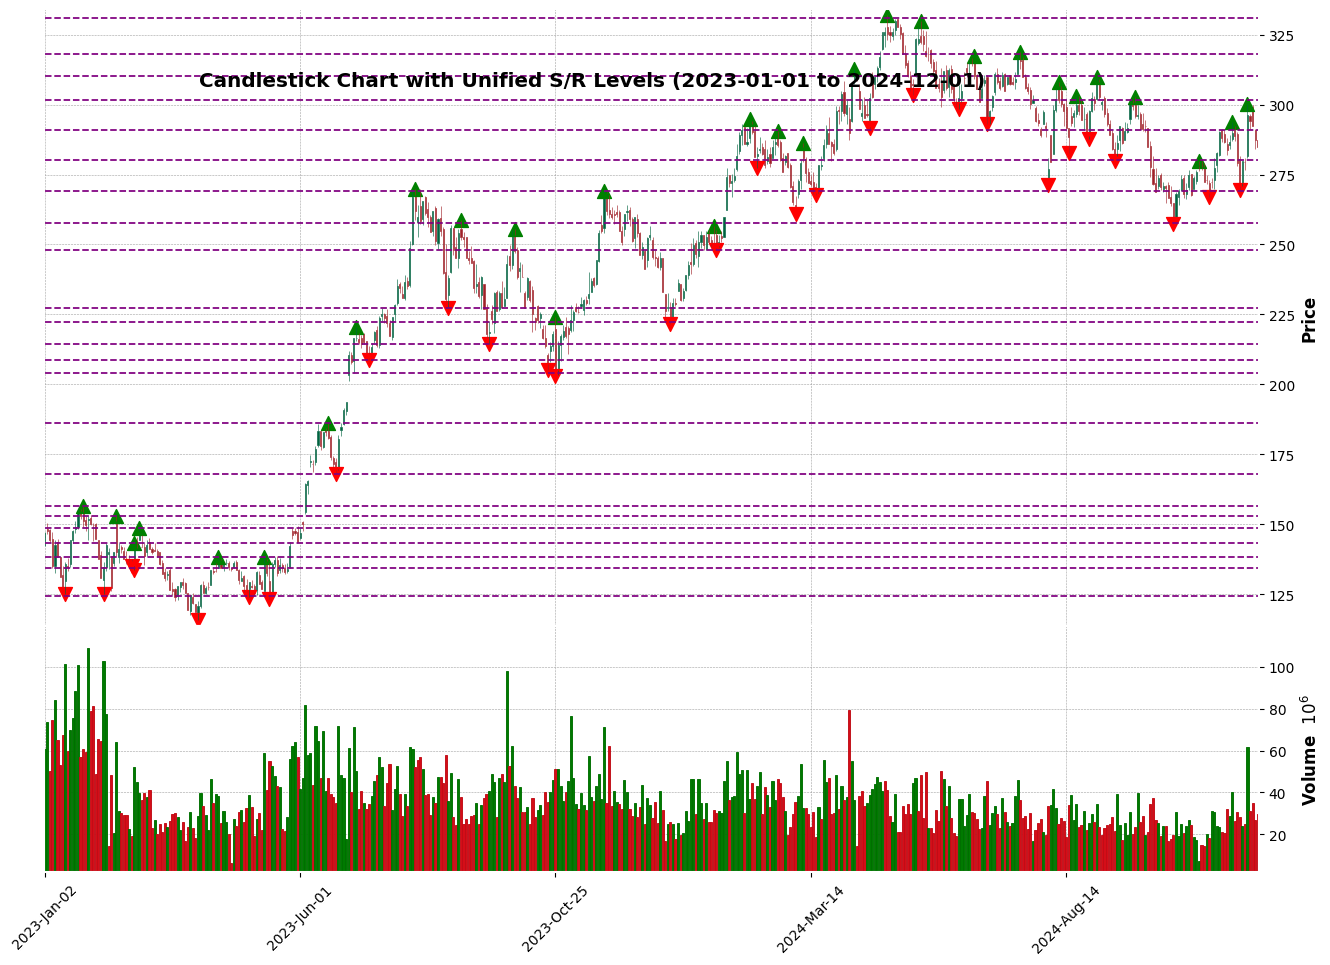

Candlestick chart plotted successfully.
Support/Resistance Levels: [np.float64(115.9), np.float64(124.42499999999998), np.float64(134.199995), np.float64(138.25), np.float64(143.39999), np.float64(148.7), np.float64(152.8), np.float64(156.39999), np.float64(168.10001), np.float64(186.2), np.float64(204.1), np.float64(208.60001), np.float64(214.60001), np.float64(222.13334), np.float64(227.3), np.float64(248.0), np.float64(257.790004), np.float64(269.091665), np.float64(280.0625), np.float64(291.10714285714283), np.float64(301.65), np.float64(310.1666666666667), np.float64(318.125), np.float64(331.0)]


In [96]:
if __name__ == "__main__":
    import sys
    import os

    try:
        # Example CSV path
        csv_file = 'data/BIST_DLY_THYAO, 1D_2b8b3.csv'

        # Check if the CSV file exists
        if not os.path.exists(csv_file):
            print(f"CSV file '{csv_file}' does not exist. Please check the path.")
            sys.exit(1)

        # Read and display column names
        data = pd.read_csv(csv_file)
        print("CSV Columns:", data.columns.tolist())

        # Call the updated function
        filtered_data, sr_levels = plot_and_save_candlestick_with_levels_corrected_pivots(
            csv_path=csv_file,          # Path to your original CSV file
            start_date='2023-01-01',    # Start date for the range
            end_date='2024-12-01',      # End date for the range
            abs_eps=3,               # Absolute DBSCAN eps
            min_samples=1,              # Minimum number of points to form a cluster
            output_csv_path="candlestick_with_pivot_points.csv",  # Save output CSV
            pivot_window=5              # Number of preceding candles to consider for pivot detection
        )

        # Print S/R levels
        print("Support/Resistance Levels:", sr_levels)

    except Exception as e:
        print("An error occurred:", e)

## Plot Statistics

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_statistics(filtered_data, sr_levels):
    """
    Calculate statistics for S/R levels and pivots.

    Parameters:
        filtered_data (pd.DataFrame): Filtered dataset with pivot information.
        sr_levels (list): List of unified S/R levels.

    Returns:
        stats (dict): Dictionary of calculated statistics.
    """
    stats = {}

    # Calculate % differences between consecutive S/R levels
    sr_differences = np.diff(sr_levels)
    sr_percent_differences = (sr_differences / sr_levels[:-1]) * 100
    stats['avg_sr_percent_diff'] = np.mean(sr_percent_differences)
    stats['sr_percent_differences'] = sr_percent_differences

    # Extract pivot highs and lows
    pivot_highs = filtered_data['Pivot Highs'].dropna()
    pivot_lows = filtered_data['Pivot Lows'].dropna()

    # Calculate differences between consecutive pivot points (alternating highs and lows)
    pivot_differences = []
    last_pivot = None
    for idx, row in filtered_data.iterrows():
        if not np.isnan(row['Pivot Highs']):
            if last_pivot is not None:
                pivot_differences.append(row['Pivot Highs'] - last_pivot)
            last_pivot = row['Pivot Highs']
        elif not np.isnan(row['Pivot Lows']):
            if last_pivot is not None:
                pivot_differences.append(row['Pivot Lows'] - last_pivot)
            last_pivot = row['Pivot Lows']

    stats['avg_pivot_diff'] = np.mean(pivot_differences)
    stats['pivot_differences'] = pivot_differences

    return stats

In [54]:
def plot_statistics(stats):
    """
    Plot histograms for S/R levels and pivot differences.

    Parameters:
        stats (dict): Dictionary containing statistics.
    """
    # Histogram of % differences between consecutive S/R levels
    plt.figure(figsize=(10, 5))
    plt.hist(stats['sr_percent_differences'], bins=10, color='purple', alpha=0.7)
    plt.title("Distribution of % Differences Between S/R Levels")
    plt.xlabel("% Difference")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Histogram of differences between consecutive pivots
    plt.figure(figsize=(10, 5))
    plt.hist(stats['pivot_differences'], bins=10, color='blue', alpha=0.7)
    plt.title("Distribution of Differences Between Consecutive Pivots")
    plt.xlabel("Difference")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


Total Pivots Detected: 31
Identified S/R Levels: [np.float64(248.0), np.float64(257.0), np.float64(260.75), np.float64(268.875), np.float64(280.0625), np.float64(291.10714285714283), np.float64(301.65), np.float64(310.1666666666667), np.float64(318.125), np.float64(331.0)]


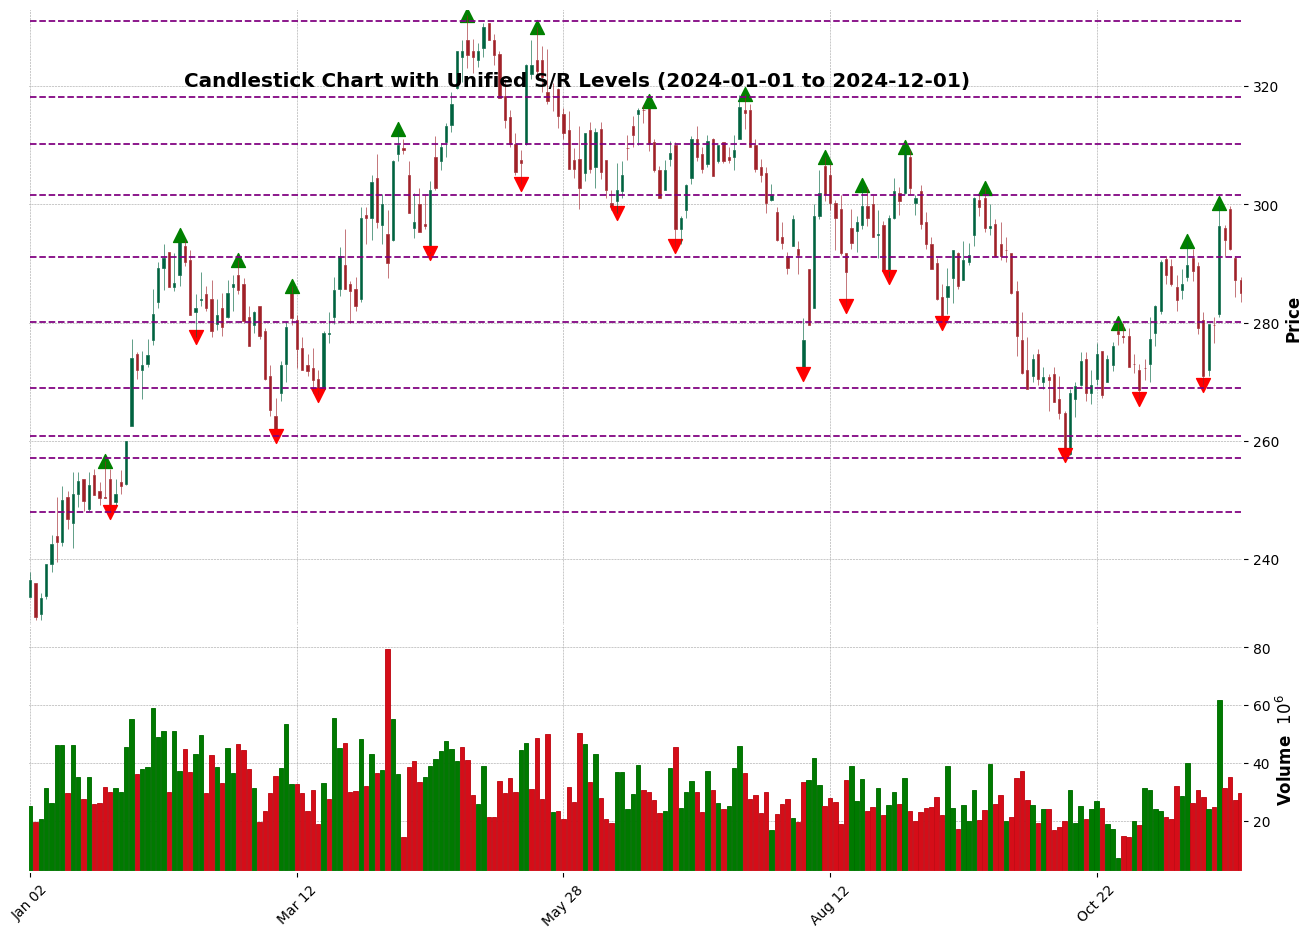

Candlestick chart plotted successfully.
Average % Difference Between S/R Lines: 3.262961800460893
Average Difference Between Consecutive Pivots: 1.4583333333333333


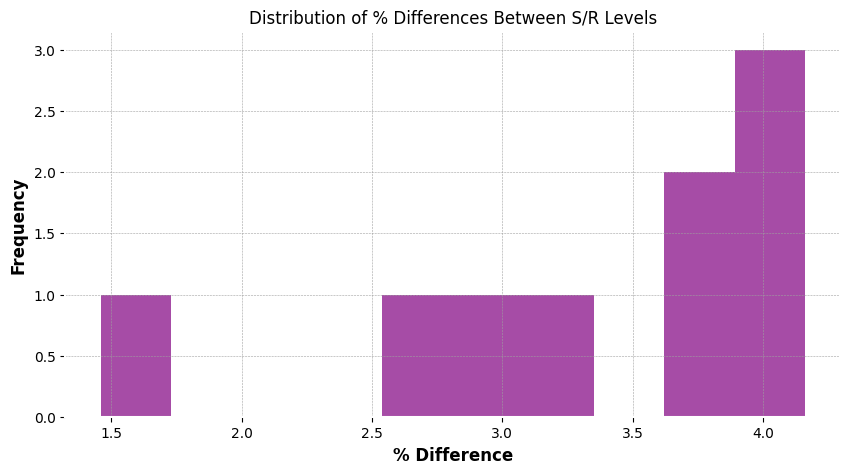

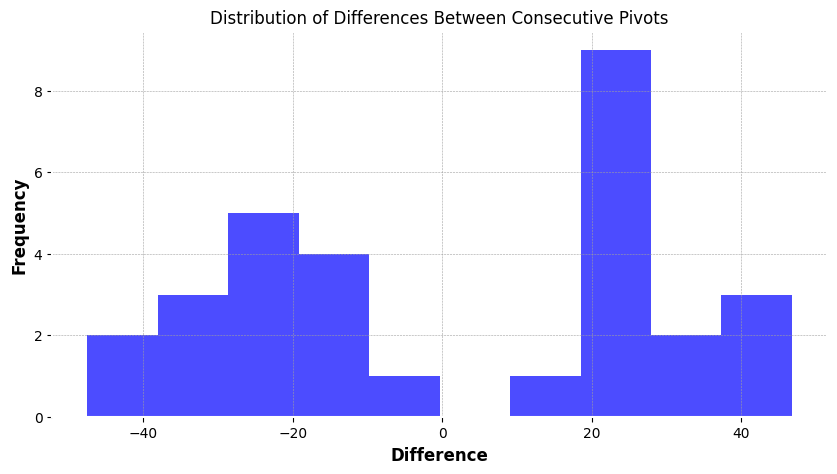

In [60]:
# Call the updated function and retrieve filtered data and S/R levels
filtered_data, sr_levels = plot_and_save_candlestick_with_levels_corrected_pivots(
    csv_path=csv_file,          # Path to your original CSV file
    start_date='2024-01-01',    # Start date for the range
    end_date='2024-12-01',      # End date for the range
    eps_factor=0.03,            # Dynamic DBSCAN eps as 2% of the price range
    min_samples=1,              # Minimum number of points to form a cluster
    output_csv_path="candlestick_with_pivot_points.csv",  # Save output CSV
    pivot_window=5              # Number of preceding candles to consider for pivot detection
)

# If there are no S/R levels, skip statistics
if len(sr_levels) > 0:
    # Calculate statistics
    stats = calculate_statistics(filtered_data, sr_levels)

    # Print calculated statistics
    print("Average % Difference Between S/R Lines:", stats['avg_sr_percent_diff'])
    print("Average Difference Between Consecutive Pivots:", stats['avg_pivot_diff'])

    # Plot statistics
    plot_statistics(stats)
else:
    print("No S/R levels detected. Statistics will not be calculated.")